# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression




In [77]:
future = pd.read_excel("data/futures.xlsx", header=0)

In [78]:
future["date"]= pd.to_datetime(future["date"])
future.ffill(inplace=True)
future = future[future['date'] <= "2023-01-01"]
future.head()

,date,TRFRBYc1,TRFRBMc1,TRFRBFVMG6,TRFRBFVMH6,TRFRBFVMJ6,TRFRBFVMK6,TRFRBFVMM6,TRFRBFVMN6,TRFRBFVMQ6,...,TRFRBFVMH7,TRFRBFVMJ7,TRFRBFVMK7,TRFRBFVMM7,TRFRBFVMN7,TRFRBFVMQ7,TRFRBFVMU7,TRFRBFVMV7,TRFRBFVMX7,TRFRBFVMZ7
789,2022-12-30,245.00,202.0,162.85,147.12,115.84,103.95,101.40,102.91,110.96,...,135.40,105.99,92.64,92.72,94.45,100.84,117.78,152.02,163.86,162.26
790,2022-12-29,269.75,230.0,161.31,145.57,114.32,102.43,99.88,101.27,109.32,...,134.56,104.78,91.57,91.86,93.21,99.71,116.73,151.04,162.93,161.33
791,2022-12-28,274.00,240.0,166.20,151.23,109.20,99.74,97.55,98.32,106.83,...,141.58,99.22,88.97,90.63,91.19,97.40,112.55,159.32,168.87,166.42
792,2022-12-27,276.00,266.0,168.71,153.69,108.19,98.71,96.48,97.22,105.71,...,143.68,98.29,88.26,89.80,90.48,96.64,111.50,158.52,168.02,165.58
793,2022-12-26,276.00,266.0,166.46,156.30,95.84,93.83,91.22,90.94,101.84,...,139.45,78.74,78.48,80.38,79.59,86.55,93.88,158.16,158.22,156.62


In [79]:
# Lecture et traitement des fichiers Spot22, Spot23, Spot24, Spot25
spot_files = ["data/spot_price_16.xlsx","data/spot_price_17.xlsx","data/spot_price_18.xlsx","data/spot_price_19.xlsx","data/spot_price_20.xlsx","data/spot_price_21.xlsx","data/spot_price_22.xlsx", "data/spot_price_23.xlsx", "data/spot_price_24.xlsx", "data/spot_price_25.xlsx"]
spot_data = []

for file in spot_files:
    spot = pd.read_excel(file)
    spot['Date'] = spot['Date'].str.split(' - ').str[0]  # Prendre uniquement le début de la plage
    spot['Date'] = pd.to_datetime(spot['Date'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    spot = spot.dropna(subset=['Date'])  # Suppression des lignes avec des dates invalides
    daily = spot.groupby(spot['Date'].dt.date)['Day-ahead'].mean().reset_index()
    daily.rename(columns={'Date': 'date', 'Day-ahead': 'price'}, inplace=True)
    spot_data.append(daily)

# Fusion des bases de données
spot_merged = pd.concat(spot_data).groupby('date', as_index=False)['price'].mean()

# Affichage des premières lignes du résultat
spot_merged.head()


,date,price
0,2016-01-01,23.888750
1,2016-01-02,23.198750
2,2016-01-03,18.003750
3,2016-01-04,28.229583
4,2016-01-05,33.877083


In [80]:
spot_merged.loc[spot_merged['price'] <= 0, 'price'] = np.nan
spot_merged['price'] = spot_merged['price'].ffill()

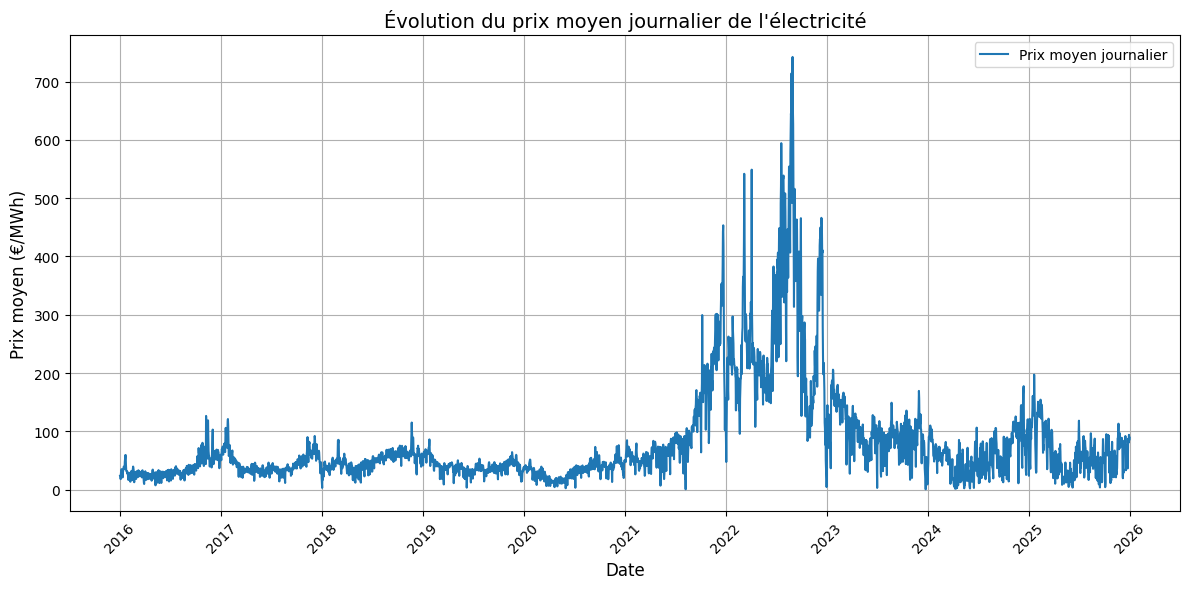

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(spot_merged['date'], spot_merged['price'], linestyle='-', label='Prix moyen journalier')
plt.title("Évolution du prix moyen journalier de l'électricité", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
# Convertir la colonne 'date' en type datetime64 pour éviter les incompatibilités de types
spot_merged['date'] = pd.to_datetime(spot_merged['date'])

# Filtrer les données pour conserver uniquement les dates à partir du 1er janvier 2023
spot_merged = spot_merged[spot_merged['date'] >= pd.Timestamp('2023-01-01')]


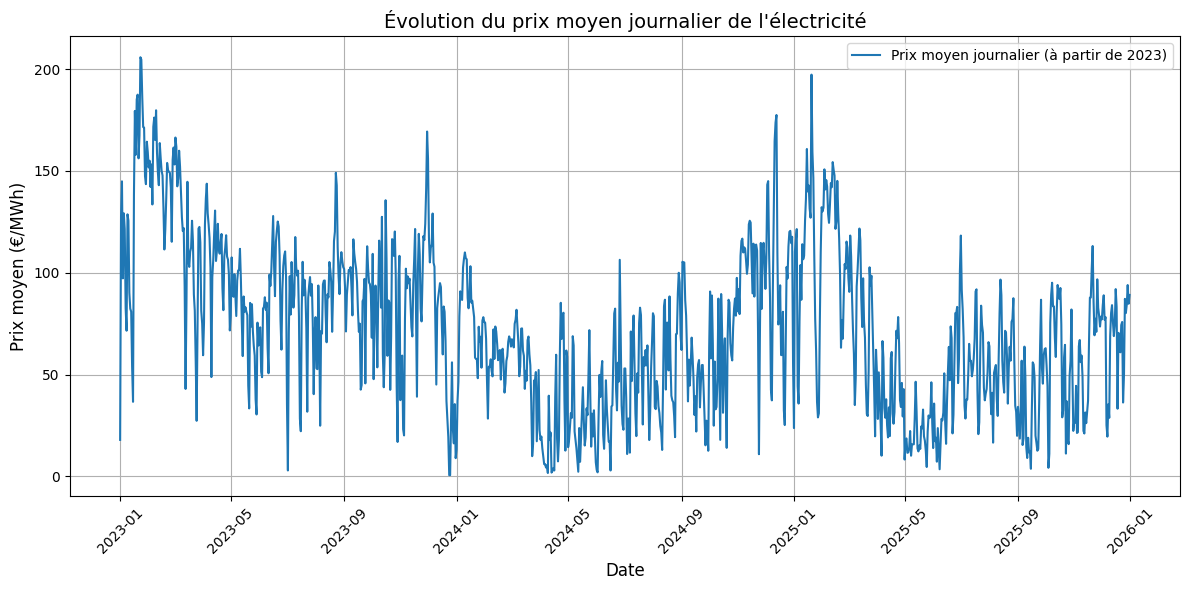

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(spot_merged['date'], spot_merged['price'], linestyle='-', label='Prix moyen journalier (à partir de 2023)')
plt.title("Évolution du prix moyen journalier de l'électricité", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [84]:
# Ajouter des colonnes "jour", "mois", "semaine" et "saison"
spot_merged['jour'] = spot_merged['date'].dt.day_name()
spot_merged['mois'] = spot_merged['date'].dt.month_name()
spot_merged['semaine'] = spot_merged['date'].dt.isocalendar().week
spot_merged['saison'] = spot_merged['date'].dt.month % 12 // 3 + 1
spot_merged['saison'] = spot_merged['saison'].map({1: 'Hiver', 2: 'Printemps', 3: 'Été', 4: 'Automne'})


Statistiques descriptives par jour de la semaine:
           count       mean        std        min        25%        50%  \
jour                                                                      
Friday     156.0  77.547948  37.992099   6.008333  54.388229  78.793073   
Monday     157.0  76.072197  40.311244   0.600000  46.892917  73.590417   
Saturday   156.0  61.733245  36.331542   1.858750  31.779896  56.751875   
Sunday     157.0  51.744751  37.181654   0.597500  19.778750  45.536667   
Thursday   156.0  79.254841  39.663877   7.231667  52.840833  80.168281   
Tuesday    157.0  79.423432  40.004813   1.659167  49.847917  77.178333   
Wednesday  157.0  80.163034  38.417830  13.785417  51.245417  82.275833   

                  75%         max  
jour                               
Friday      99.009062  187.445833  
Monday     101.276667  205.830000  
Saturday    86.250208  156.182500  
Sunday      74.291250  167.334167  
Thursday   105.515104  185.080833  
Tuesday    105.366250 

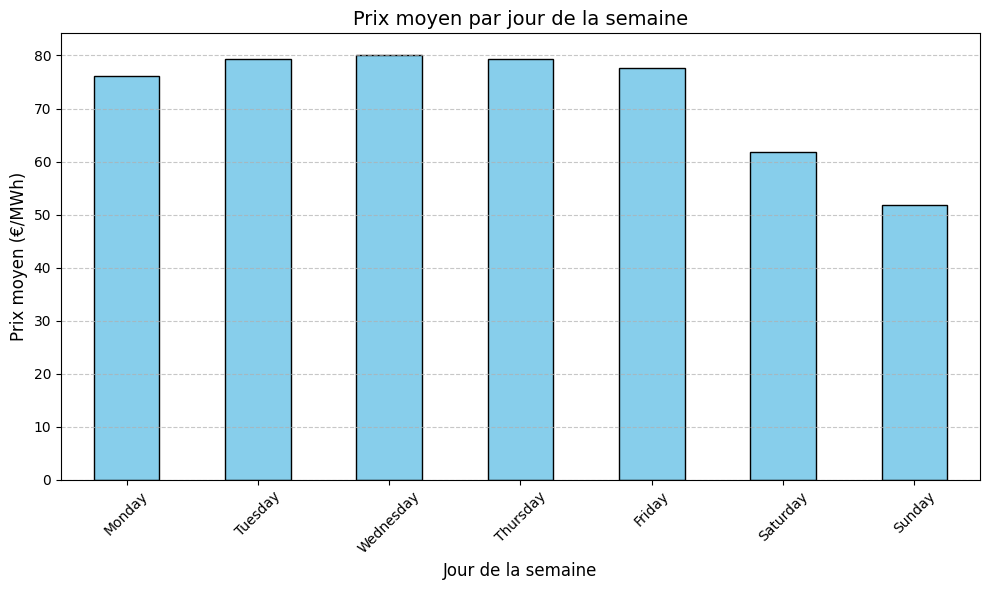

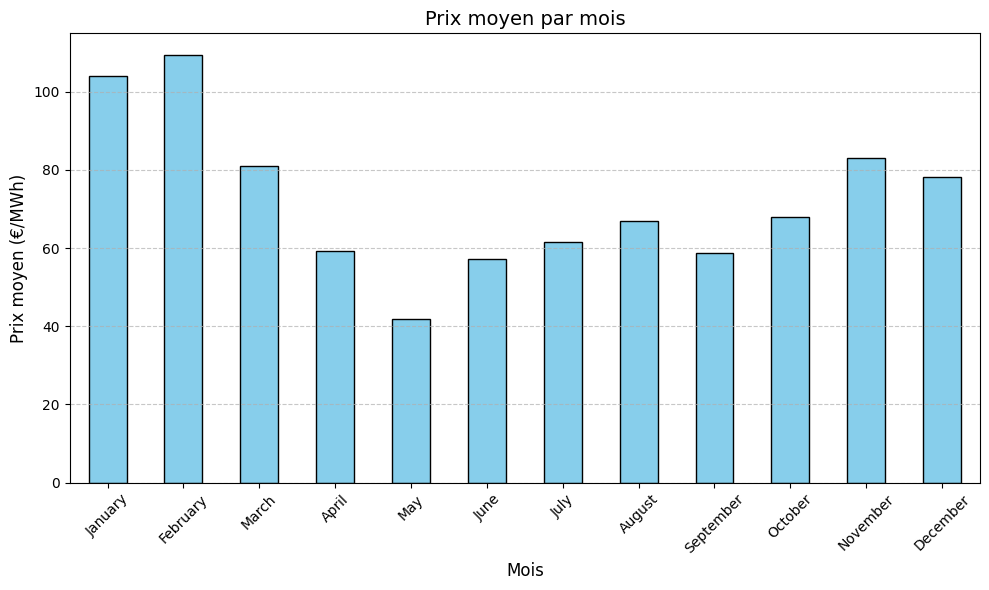

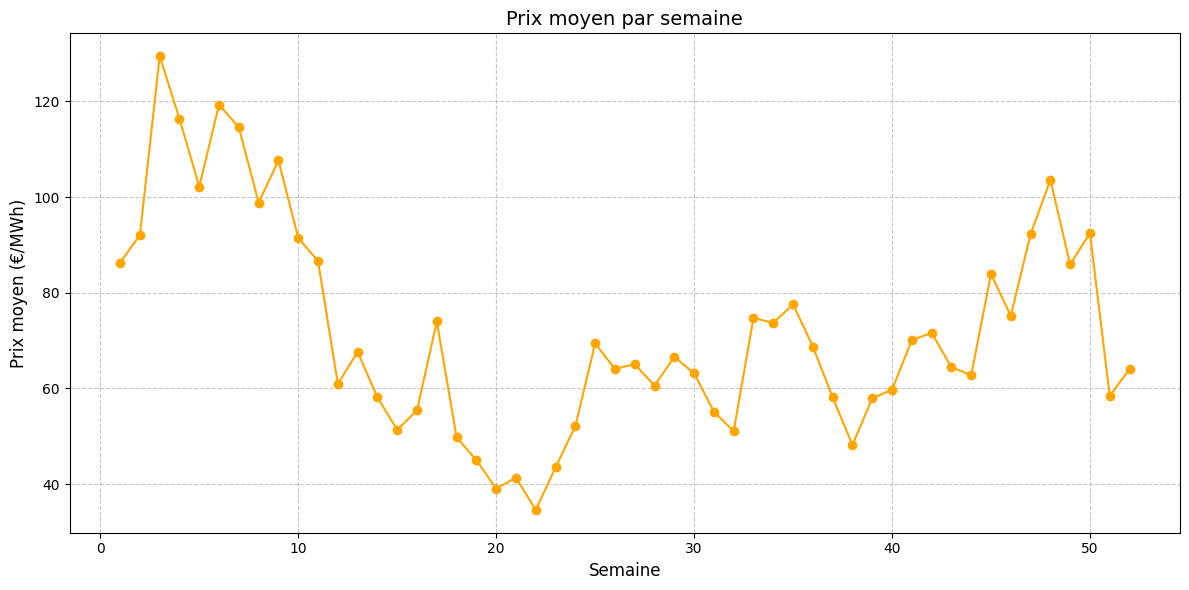

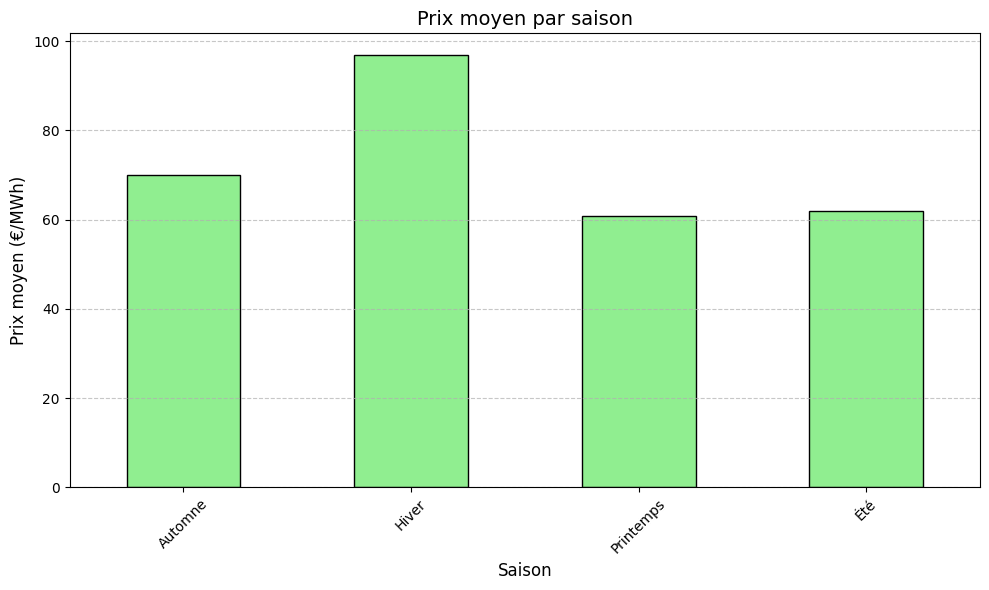

<Figure size 1200x800 with 0 Axes>

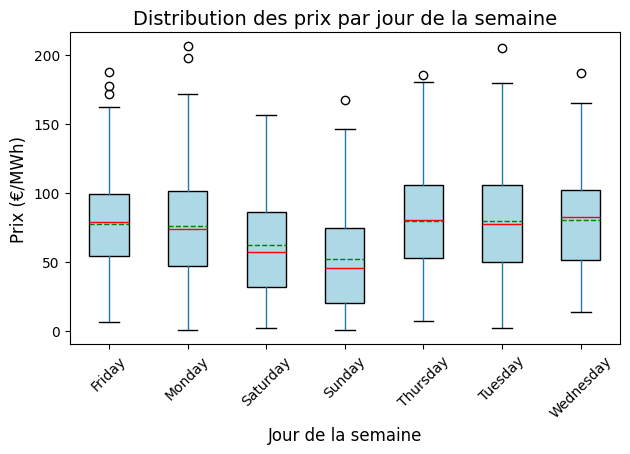

<Figure size 1200x800 with 0 Axes>

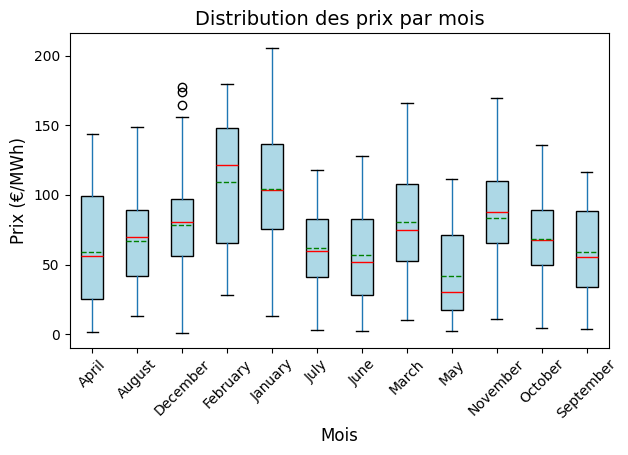

<Figure size 1200x800 with 0 Axes>

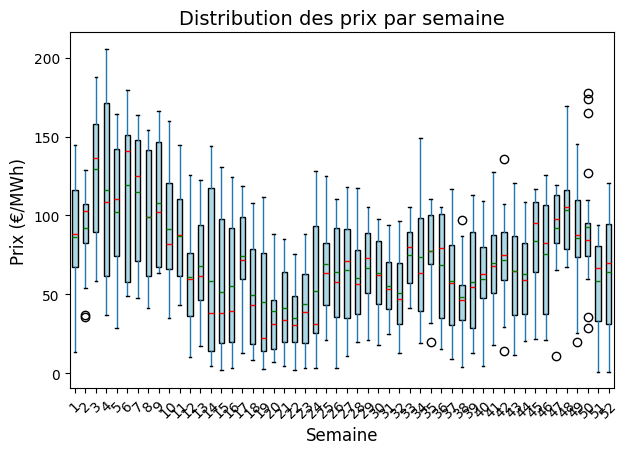

<Figure size 1200x800 with 0 Axes>

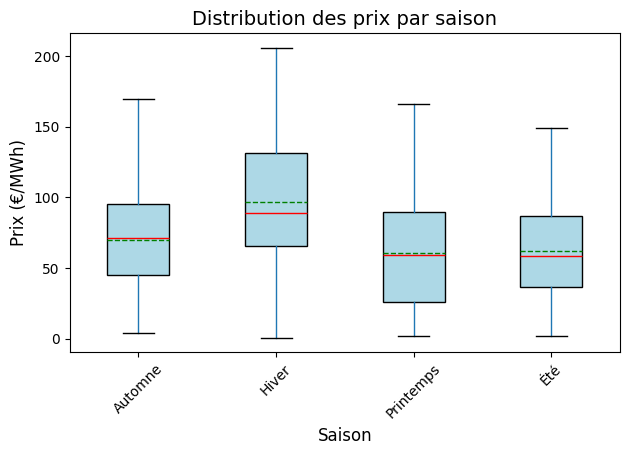

In [85]:
# Statistiques descriptives pour mesurer la saisonnalité par jour, mois, semaine et saison
stats_by_day = spot_merged.groupby('jour')['price'].describe()
stats_by_month = spot_merged.groupby('mois')['price'].describe()
stats_by_week = spot_merged.groupby('semaine')['price'].describe()
stats_by_season = spot_merged.groupby('saison')['price'].describe()

print("Statistiques descriptives par jour de la semaine:")
print(stats_by_day)
print("\nStatistiques descriptives par mois:")
print(stats_by_month)
print("\nStatistiques descriptives par semaine:")
print(stats_by_week)
print("\nStatistiques descriptives par saison:")
print(stats_by_season)

# Graphique de la moyenne des prix par jour de la semaine
plt.figure(figsize=(10, 6))
spot_merged.groupby('jour')['price'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Prix moyen par jour de la semaine", fontsize=14)
plt.xlabel("Jour de la semaine", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par mois
plt.figure(figsize=(10, 6))
spot_merged.groupby('mois')['price'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'
]).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Prix moyen par mois", fontsize=14)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par semaine
plt.figure(figsize=(12, 6))
spot_merged.groupby('semaine')['price'].mean().plot(color='orange', linestyle='-', marker='o')
plt.title("Prix moyen par semaine", fontsize=14)
plt.xlabel("Semaine", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par saison
plt.figure(figsize=(10, 6))
spot_merged.groupby('saison')['price'].mean().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Prix moyen par saison", fontsize=14)
plt.xlabel("Saison", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par jour de la semaine
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='jour', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par jour de la semaine", fontsize=14)
plt.suptitle("")  # Supprimer le titre par défaut de boxplot
plt.xlabel("Jour de la semaine", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par mois
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='mois', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par mois", fontsize=14)
plt.suptitle("")
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par semaine
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='semaine', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par semaine", fontsize=14)
plt.suptitle("")
plt.xlabel("Semaine", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par saison
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='saison', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par saison", fontsize=14)
plt.suptitle("")
plt.xlabel("Saison", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [86]:
# 1. Prépare les données (Log-Prix & Mois continu pour lissage)
spot_merged['log_price'] = np.log(spot_merged['price'])

spot_merged['t_smooth'] = spot_merged['date'].dt.month + (spot_merged['date'].dt.day - 1) / spot_merged['date'].dt.days_in_month

# 2. Agrégation Mensuelle (Calibration sur 12 points seulement)
monthly = spot_merged.groupby(spot_merged['date'].dt.month)['log_price'].mean()
X_fit, Y_fit = monthly.index.values, monthly.values

# 3. Fonction Fourier dynamique
def fourier(x, *a):
    res = a[0]
    for i in range((len(a)-1)//2):
        k = 2 * np.pi * (i+1) * x / 12
        res += a[2*i+1] * np.sin(k) + a[2*i+2] * np.cos(k)
    return res

# 4. Calibration (Trouve le meilleur ordre entre 1 et 3)
best = (float('inf'), None)
for order in range(1, 6):
    try:
        # p0 : Moyenne + des petits coeffs
        popt, _ = curve_fit(fourier, X_fit, Y_fit, p0=[np.mean(Y_fit)] + [0.1]*(2*order))
        resid = np.sum((Y_fit - fourier(X_fit, *popt))**2)
        if resid < best[0]: best = (resid, popt)
    except: pass

# 5. Application & Calcul de Xt
# On applique les params mensuels sur l'axe temporel lisse journalier
spot_merged['seasonality'] = fourier(spot_merged['t_smooth'], *best[1])
spot_merged['Xt'] = spot_merged['log_price'] - spot_merged['seasonality']

print(f"Saisonnalité calibrée (Ordre {(len(best[1])-1)//2})")

Saisonnalité calibrée (Ordre 5)


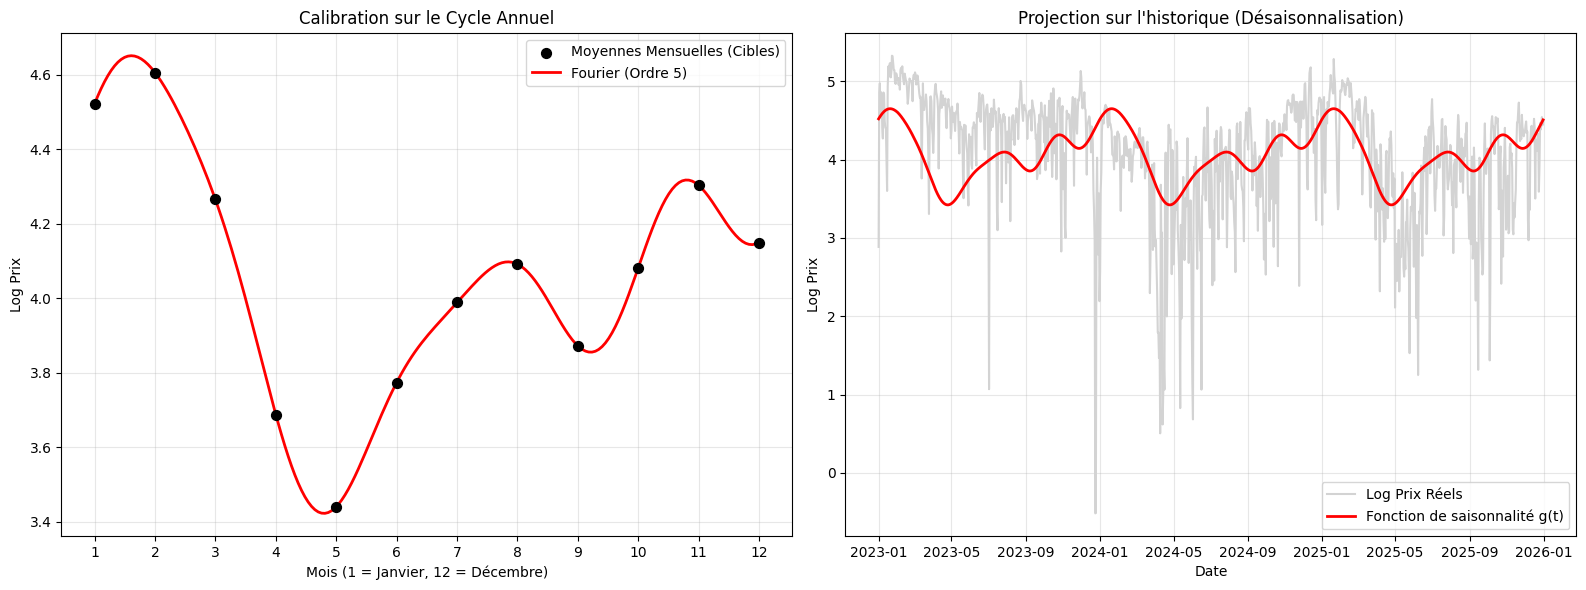

In [87]:
plt.figure(figsize=(16, 6))

# Graphique 1 : Calibration sur le cycle annuel
plt.subplot(1, 2, 1)
# Les points mensuels (Moyennes)
plt.scatter(X_fit, Y_fit, color='black', s=50, label='Moyennes Mensuelles (Cibles)', zorder=3)

# La courbe lissée (Fourier)
x_smooth_plot = np.linspace(1, 12, 200)
y_smooth_plot = fourier(x_smooth_plot, *best[1])
plt.plot(x_smooth_plot, y_smooth_plot, color='red', linewidth=2, label=f'Fourier (Ordre {(len(best[1])-1)//2})')

plt.title("Calibration sur le Cycle Annuel")
plt.xlabel("Mois (1 = Janvier, 12 = Décembre)")
plt.ylabel("Log Prix")
plt.xticks(np.arange(1, 13)) # Force l'affichage de 1 à 12
plt.grid(True, alpha=0.3)
plt.legend()

# Graphique 2 : Projection sur l'historique
plt.subplot(1, 2, 2)
# Les log-prix réels
plt.plot(spot_merged['date'], spot_merged['log_price'], color='lightgray', label='Log Prix Réels')

# Fonction de saisonnalité lissée
plt.plot(spot_merged['date'], spot_merged['seasonality'], color='red', linewidth=2, label='Fonction de saisonnalité g(t)')

plt.title("Projection sur l'historique (Désaisonnalisation)")
plt.xlabel("Date")
plt.ylabel("Log Prix")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Itérations de filtrage : 4
----------------------------------------
Fréquence des sauts (J)  : 9.01 sauts/an
Taille moyenne saut (Mu) : 28.8719
Volatilité saut (Sigma)  : 63.1351
----------------------------------------


<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_2478/2118692081.py:90: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(limit + base_signal_mean, color='green', linestyle='--', alpha=0.5, label=f'Seuil (+/- {SIGMA_THRESHOLD}$\sigma$)')
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_2478/2118692081.py:58: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` 

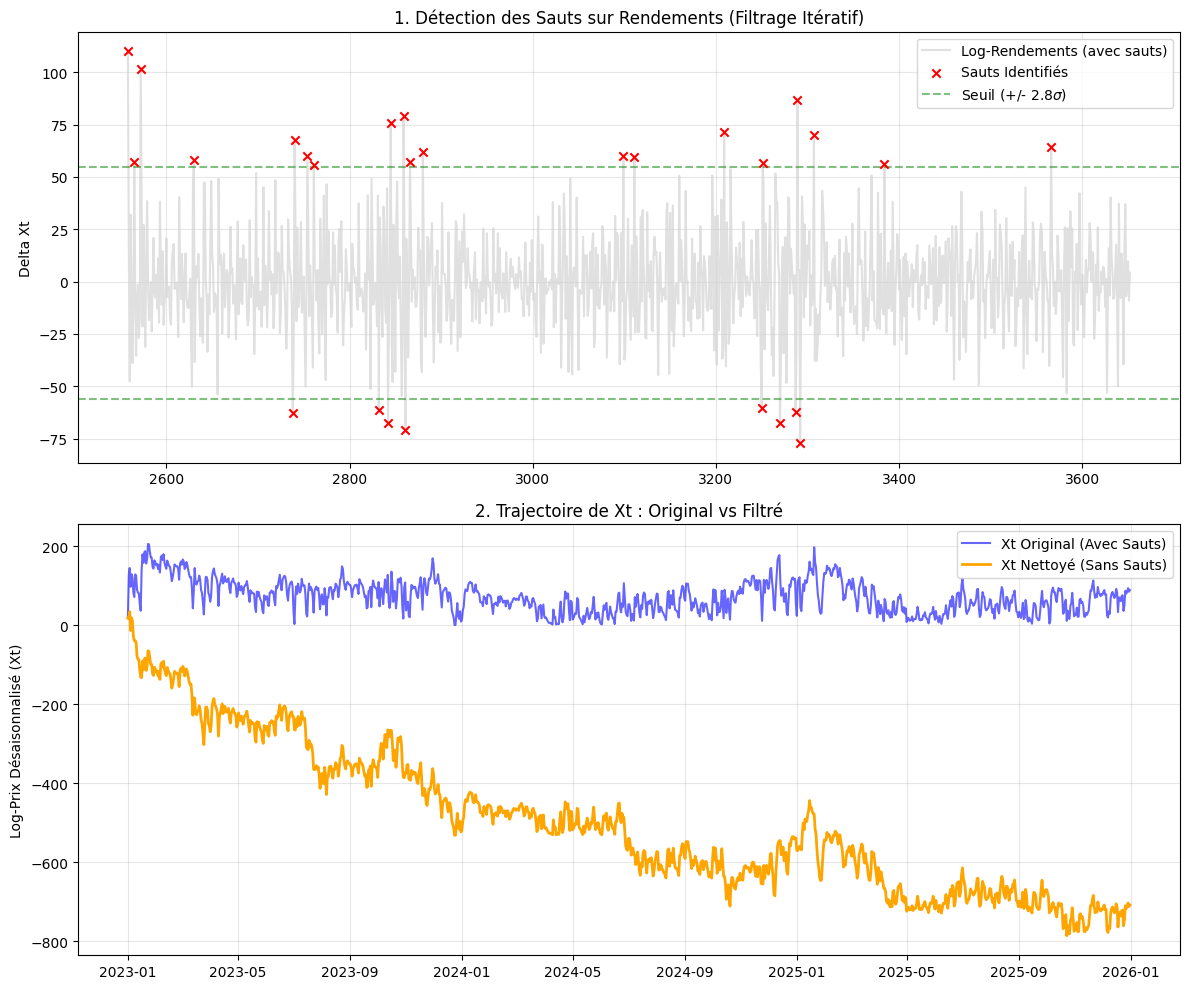

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Code Existant ---
# Calcul des log-rendements initiaux
returns = spot_merged['price'].diff().dropna()
current_series = returns.copy()
jumps_found = []
jump_indices = []

# Seuil de détection des sauts (règle des 3-sigmas)
SIGMA_THRESHOLD = 2.8

iteration = 0
while True:
    iteration += 1
    std_dev = current_series.std()
    mean_val = current_series.mean() # Calcul de la moyenne locale pour centrer si besoin

    # Détection des outliers par rapport à la déviation standard
    is_jump = np.abs(current_series - mean_val) > SIGMA_THRESHOLD * std_dev

    if not is_jump.any():
        break

    new_jumps = current_series[is_jump]
    jumps_found.extend(new_jumps.values)
    jump_indices.extend(new_jumps.index)

    # On retire les sauts pour l'itération suivante (affinement du sigma)
    current_series = current_series[~is_jump]

print(f"Itérations de filtrage : {iteration}")

# --- AJOUT : Reconstruction de Xt sans sauts ---

# 1. Création d'une série de rendements "nettoyés"
returns_clean = returns.copy()

# 2. Remplacement des sauts par la moyenne du signal de base (neutralisation)
# On utilise la moyenne de 'current_series' (le signal sans sauts) pour combler les trous
base_signal_mean = current_series.mean()
returns_clean.loc[jump_indices] = base_signal_mean

# 3. Reconstruction par somme cumulative (Integration)
# On part du premier point connu de Xt pour ré-ancrer la série
x0 = spot_merged['price'].iloc[0]

# On recrée la série temporelle.
# Note : returns commence à t=1, donc cumsum() nous donne Xt - X0. On rajoute X0.
xt_clean_values = returns_clean.cumsum() + x0

# On sauvegarde dans le DataFrame (en alignant les index)
spot_merged['price_clean'] = np.nan # Init
spot_merged.loc[xt_clean_values.index, 'price_clean'] = xt_clean_values
# On remplit la première valeur (t=0) qui a sauté avec le diff()
spot_merged['price_clean'].iloc[0] = x0

# --- Statistiques et Affichage (Code existant + Ajout Plot Xt) ---

# Paramètres des Sauts (Jumps)
jumps_array = np.array(jumps_found)

# J : Nombre de sauts par an
if len(spot_merged) > 1:
    years = (spot_merged['date'].max() - spot_merged['date'].min()).days / 365.25
else:
    years = 1 # Fallback
lambda_jump = len(jumps_array) / years if years > 0 else 0

# Mu et Sigma du saut
mu_jump = jumps_array.mean() if len(jumps_array) > 0 else 0
sigma_jump = jumps_array.std() if len(jumps_array) > 0 else 0

print("-" * 40)
print(f"Fréquence des sauts (J)  : {lambda_jump:.2f} sauts/an")
print(f"Taille moyenne saut (Mu) : {mu_jump:.4f}")
print(f"Volatilité saut (Sigma)  : {sigma_jump:.4f}")
print("-" * 40)

# Plot 1 : Les Rendements et Sauts détectés
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(returns.index, returns, color='lightgray', label='Log-Rendements (avec sauts)', alpha=0.7)
plt.scatter(jump_indices, jumps_found, color='red', marker='x', label='Sauts Identifiés', zorder=5)
# Seuil final sur le signal épuré
limit = SIGMA_THRESHOLD * current_series.std()
plt.axhline(limit + base_signal_mean, color='green', linestyle='--', alpha=0.5, label=f'Seuil (+/- {SIGMA_THRESHOLD}$\sigma$)')
plt.axhline(-limit + base_signal_mean, color='green', linestyle='--', alpha=0.5)
plt.title("1. Détection des Sauts sur Rendements (Filtrage Itératif)")
plt.ylabel("Delta Xt")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2 : Comparaison Xt vs Xt_clean (AJOUT)
plt.subplot(2, 1, 2)
plt.plot(spot_merged['date'], spot_merged['price'], label='Xt Original (Avec Sauts)', color='blue', alpha=0.6)
plt.plot(spot_merged['date'], spot_merged['price_clean'], label='Xt Nettoyé (Sans Sauts)', color='orange', linewidth=2)
plt.title("2. Trajectoire de Xt : Original vs Filtré")
plt.ylabel("Log-Prix Désaisonnalisé (Xt)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

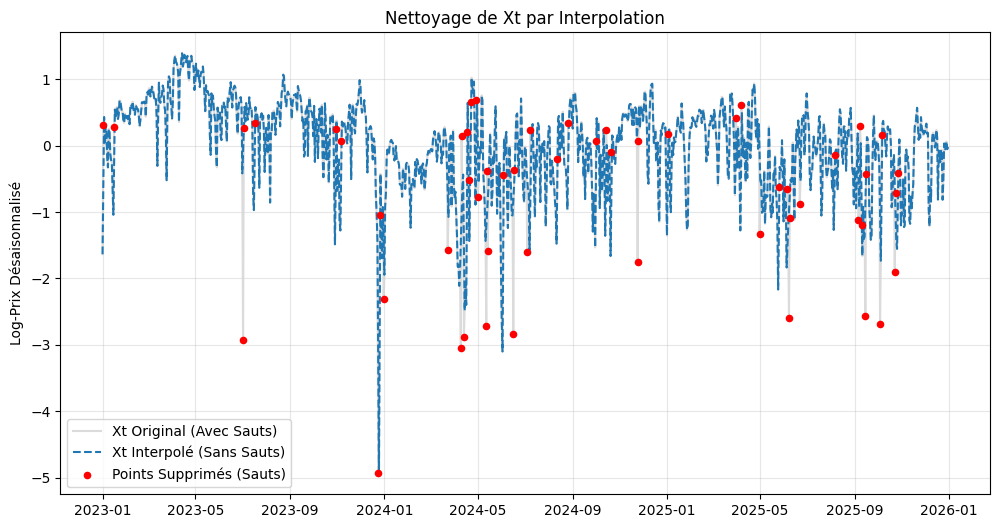

Nouveau Sigma calibré (sur série interpolée) : 824.66%


In [89]:
# --- 1. Filtrage (Code identique au précédent) ---
returns = spot_merged['log_price'].diff().dropna()
current_series = returns.copy()
jumps_found = []
jump_indices = []
SIGMA_THRESHOLD = 3.0

iteration = 0
while True:
    iteration += 1
    std_dev = current_series.std()
    mean_val = current_series.mean()
    is_jump = np.abs(current_series - mean_val) > SIGMA_THRESHOLD * std_dev
    if not is_jump.any():
        break
    new_jumps = current_series[is_jump]
    jump_indices.extend(new_jumps.index) # On stocke les indices des sauts
    current_series = current_series[~is_jump]

# --- 2. Reconstruction par Interpolation (NOUVEAU) ---

# On copie la série originale Xt (niveau)
spot_merged['Xt_clean'] = spot_merged['Xt'].copy()

# On identifie les points "pollués" par les sauts.
# Si un rendement à l'instant t est un saut, cela veut dire que la valeur Xt est aberrante.
# On met ces valeurs à NaN pour pouvoir les interpoler.
spot_merged.loc[jump_indices, 'Xt_clean'] = np.nan

# On applique l'interpolation linéaire
# method='linear' est adapté pour un mouvement brownien discret
# limit_direction='both' permet de gérer les sauts au tout début ou à la toute fin
spot_merged['Xt_clean'] = spot_merged['Xt_clean'].interpolate(method='linear', limit_direction='both')

# --- 3. Recalcul des rendements propres pour la calibration ---
# Maintenant que Xt est propre, on recalcule les rendements "clean"
# C'est sur CETTE série que vous ferez la régression pour Alpha et Sigma
clean_returns = spot_merged['Xt_clean'].diff().dropna()

# --- Visualisation ---
plt.figure(figsize=(12, 6))
plt.plot(spot_merged['date'], spot_merged['Xt'], label='Xt Original (Avec Sauts)', color='lightgray', alpha=0.8)
plt.plot(spot_merged['date'], spot_merged['Xt_clean'], label='Xt Interpolé (Sans Sauts)', color='tab:blue', linewidth=1.5, linestyle='--')

# On marque les points interpolés
plt.scatter(spot_merged.loc[jump_indices, 'date'], spot_merged.loc[jump_indices, 'Xt'], color='red', s=20, label='Points Supprimés (Sauts)', zorder=5)

plt.title("Nettoyage de Xt par Interpolation")
plt.ylabel("Log-Prix Désaisonnalisé")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calibration rapide sur la nouvelle série
sigma_clean = clean_returns.std() * np.sqrt(365.25)
print(f"Nouveau Sigma calibré (sur série interpolée) : {sigma_clean:.2%}")

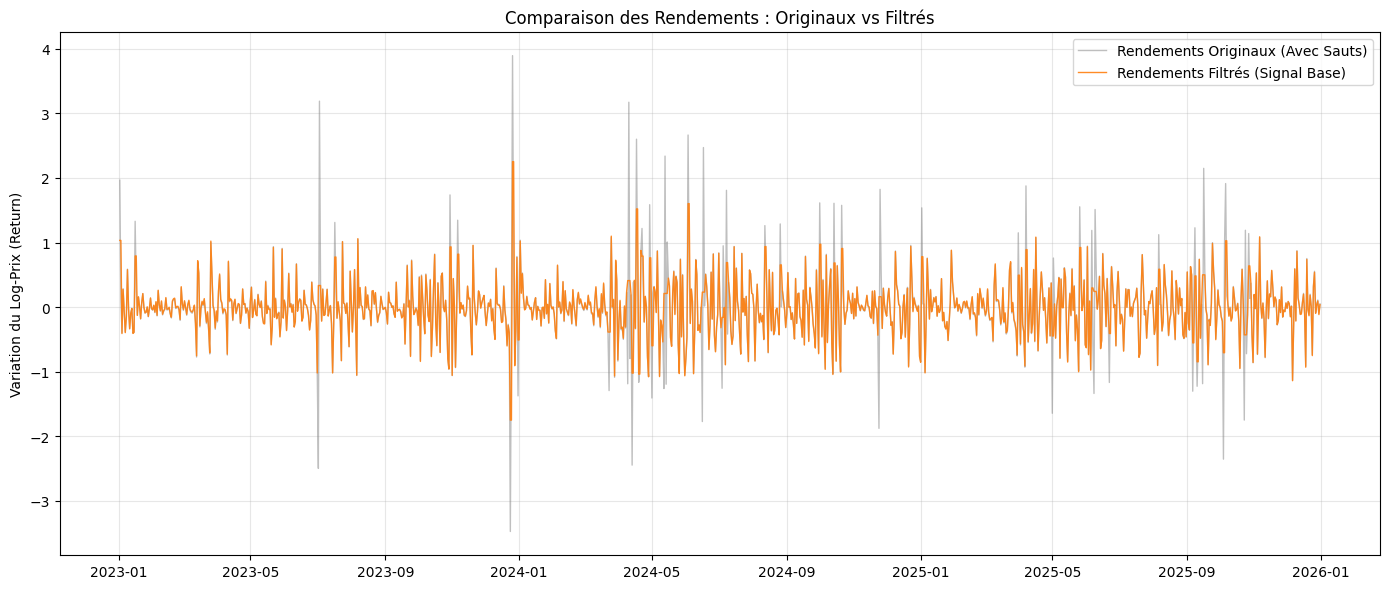

In [90]:
import matplotlib.pyplot as plt

# Recalcul des rendements pour être sûr (au cas où les variables précédentes ne sont plus en mémoire)
# Xt = Log-prix désaisonnalisé
ret_original = spot_merged['log_price'].diff()
ret_clean = spot_merged['Xt_clean'].diff()

plt.figure(figsize=(14, 6))

# 1. Rendements Originaux en gris (arrière-plan)
plt.plot(spot_merged['date'], ret_original,
         label='Rendements Originaux (Avec Sauts)',
         color='grey', alpha=0.5, linewidth=1)

# 2. Rendements Filtrés en couleur vive (avant-plan)
plt.plot(spot_merged['date'], ret_clean,
         label='Rendements Filtrés (Signal Base)',
         color='tab:orange', alpha=0.9, linewidth=1)

plt.title("Comparaison des Rendements : Originaux vs Filtrés")
plt.ylabel("Variation du Log-Prix (Return)")
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom optionnel sur une période intéressante si la série est longue
# plt.xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'))

plt.tight_layout()
plt.show()

In [91]:
# --- ÉTAPE A : COURBE FORWARD 2026 ---
# Mapping des mois Baseload France 2026 (G=Fev, H=Mar...)
mapping_2026 = {
    'TRFRBFVMG6': 2, 'TRFRBFVMH6': 3, 'TRFRBFVMJ6': 4, 'TRFRBFVMK6': 5,
    'TRFRBFVMM6': 6, 'TRFRBFVMN6': 7, 'TRFRBFVMQ6': 8, 'TRFRBFVMU6': 9,
    'TRFRBFVMV6': 10, 'TRFRBFVMX6': 11, 'TRFRBFVMZ6': 12
}

# On prend la dernière ligne de prix du fichier futures
last_row = future.iloc[-1]
dates_2026 = pd.date_range('2026-02-01', '2026-12-31', freq='D')
fwd_curve_2026 = pd.Series(index=dates_2026, dtype=float)

for code, month in mapping_2026.items():
    fwd_curve_2026[fwd_curve_2026.index.month == month] = last_row[code]

# Lissage de la courbe pour éviter les sauts brutaux entre les mois
fwd_values_2026 = fwd_curve_2026.ffill().bfill().values
print("Courbe Forward 2026 construite.")

Courbe Forward 2026 construite.


## Modélisation 
### Définition du Swing : (LSMC)

In [92]:
class SwingContract:
    def __init__(self, start_date, n_days, strike, min_daily=0, max_daily=1, min_annual=50, max_annual=250):
        self.start_date = start_date
        self.n_days = n_days
        self.strike = strike
        self.min_daily = min_daily
        self.max_daily = max_daily
        self.min_annual = min_annual
        self.max_annual = max_annual
        
def value_swing_option(contract, price_paths, discount_rate=0.04):
    """
    Valorisation LSMC retournant le prix, les bétas et la grille de volumes.
    """
    n_paths, n_steps = price_paths.shape 
    dt = 1/365
    df = np.exp(-discount_rate * dt)
    
    # Grille de volume cumulé Q (variable d'état)
    volumes = np.linspace(0, contract.max_annual, 20)
    n_vols = len(volumes)
    values = np.zeros((n_paths, n_vols))
    
    # --- AJOUT : Initialisation du stockage des bétas ---
    # Liste qui contiendra une matrice (n_vols x 3) pour chaque pas de temps t
    stored_betas = [] 
    
    # 1. Pénalité Terminale (Take-or-Pay) à t=T
    penalty_price = 1000 
    under_min = volumes < contract.min_annual
    values[:, under_min] = -penalty_price * (contract.min_annual - volumes[under_min])
    
    possible_q = [contract.min_daily, contract.max_daily] 
    
    # 2. Induction Arrière (Backward Induction)
    for t in range(n_steps - 1, -1, -1):
        prices = price_paths[:, t]
        # Base de régression : [1, S, S^2]
        P_basis = np.vstack([np.ones_like(prices), prices, prices**2]).T
        
        continuation_surface = np.zeros((n_paths, n_vols))
        # On crée une matrice pour stocker les 3 coefficients pour chaque point de volume
        step_betas = np.zeros((n_vols, 3)) 
        
        for v_idx in range(n_vols):
            y = values[:, v_idx] * df
            # Calcul des bétas par moindres carrés
            beta, _, _, _ = np.linalg.lstsq(P_basis, y, rcond=None)
            
            # --- STOCKAGE : On enregistre le cerveau du modèle à (t, v) ---
            step_betas[v_idx, :] = beta
            continuation_surface[:, v_idx] = P_basis @ beta
        
        # On ajoute les bétas de ce jour à la liste globale
        stored_betas.append(step_betas)
        
        new_values = np.full((n_paths, n_vols), -1e9)
        payoff_per_unit = prices - contract.strike
        
        for v_idx, v in enumerate(volumes):
            for q in possible_q:
                v_next = v + q
                if v_next > contract.max_annual: continue
                
                idx = np.searchsorted(volumes, v_next) - 1
                idx = np.clip(idx, 0, n_vols - 2)
                dist = volumes[idx+1] - volumes[idx]
                w = (v_next - volumes[idx]) / dist if dist > 0 else 0
                
                val_future = (1-w) * continuation_surface[:, idx] + w * continuation_surface[:, idx+1]
                total_val = (q * payoff_per_unit) + val_future
                new_values[:, v_idx] = np.maximum(new_values[:, v_idx], total_val)
        
        values = new_values

    # On inverse la liste des bétas pour qu'ils soient dans l'ordre chronologique (0 -> T-1)
    stored_betas.reverse()
    
    # On retourne le triplet nécessaire au check forward
    return np.mean(values[:, 0]), stored_betas, volumes

### Simulation MC Cartea & Figueroa (2005)

In [93]:
def simulate_final_paths(n_paths, n_days, fwd_curve, alpha_ann, sigma_d, lam_ann, mu_j, sigma_j, price_cap=4000):
    dt = 1/365.25
    paths = np.zeros((n_paths, n_days))
    paths[:, 0] = fwd_curve[0]
    x = np.zeros(n_paths)
    
    for t in range(1, n_days):
        z = np.random.normal(0, 1, n_paths)
        has_jump = np.random.rand(n_paths) < (lam_ann * dt)
        jumps = has_jump * np.random.normal(mu_j, sigma_j, n_paths)
        
        # Évolution du résidu log (Ornstein-Uhlenbeck + Sauts)
        x = x * np.exp(-alpha_ann * dt) + sigma_d * z + jumps
        
        # --- L'AJUSTEMENT DE MARTINGALE ---
        # On calcule l'écart moyen créé par les sauts et la volatilité
        adjustment = np.log(np.mean(np.exp(x)))
        
        # --- CALCUL DU PRIX ET APPLICATION DU CAP ---
        # On calcule les prix bruts
        raw_prices = fwd_curve[t] * np.exp(x - adjustment)
        
        # On écrête les valeurs au-dessus du plafond réglementaire (ex: 4000€)
        paths[:, t] = np.minimum(raw_prices, price_cap)
        
    return paths

### Résultats

In [94]:
# --- CELLULE FINALE : VALORISATION OFFICIELLE ---

# 1. Définition des paramètres de calibration (issus de tes cellules précédentes)
alpha_annuel = alpha / dt #
sigma_d = current_series.std() #
lam_ann = lambda_jump #
n_paths = 10000
# 2. Création du contrat avec ta classe SwingContract
mon_contrat = SwingContract(
    start_date='2026-02-01',
    n_days=len(fwd_values_2026),
    strike=fwd_values_2026.mean(),
    min_daily=0,
    max_daily=1,
    min_annual=50,
    max_annual=250
)

# 3. Simulation des trajectoires (Méthode Cartea & Figueroa)
# Assure-toi d'utiliser la fonction simulate_final_paths avec ajustement
paths_2026 = simulate_final_paths(
    n_paths, len(fwd_values_2026), fwd_values_2026,
    alpha_annuel, sigma_d, lam_ann, mu_jump, sigma_jump
)

# 4. Calcul de la valeur avec la Méthode 2 (Interpolée)
# On récupère le prix, le "cerveau" (betas) et la grille de volumes
prix_final, model_betas, volume_grid = value_swing_option(contract_2026, paths_2026)


print(f"VALEUR DU SWING (MÉTHODE INTERPOLÉE) : {prix_final:.2f} EUR")




NameError: name 'contract_2026' is not defined

In [960]:
# Vérification de l'absence d'arbitrage
mean_simulated_price = paths_2026.mean(axis=0)
error = np.mean(mean_simulated_price - fwd_values_2026)
print(f"Erreur moyenne par rapport aux Futures : {error:.4f} EUR")
print("Provient du cap à 4000")

Erreur moyenne par rapport aux Futures : -7.7050 EUR
Provient du cap à 4000


In [968]:
def calculate_swing_greeks(contract, base_params, fwd_curve, n_paths=1000):
    """
    Calcule les Grecques (Delta, Vega) par 'Bump and Re-price' et estime le Theta.
    """
    # 1. Prix de Référence (V0)
    # Note : on utilise mu_jump défini globalement ou passé en paramètre
    paths_ref = simulate_final_paths(n_paths, len(fwd_curve), fwd_curve, 
                                    base_params['alpha'], base_params['sigma_d'], 
                                    base_params['lambda'], mu_jump, base_params['sigma_j'])
    
    # Correction : on déballe le triplet
    v0, _, _ = value_swing_option(contract, paths_ref)

    # --- DELTA ---
    fwd_up = fwd_curve + 1.0
    paths_up = simulate_final_paths(n_paths, len(fwd_curve), fwd_up, 
                                   base_params['alpha'], base_params['sigma_d'], 
                                   base_params['lambda'], mu_jump, base_params['sigma_j'])
    
    # Correction : on déballe le triplet
    v_delta, _, _ = value_swing_option(contract, paths_up)
    delta = v_delta - v0

    # --- VEGA ---
    sigma_up = base_params['sigma_d'] + 0.01
    paths_vega = simulate_final_paths(n_paths, len(fwd_curve), fwd_curve, 
                                     base_params['alpha'], sigma_up, 
                                     base_params['lambda'], mu_jump, base_params['sigma_j'])
    
    # Correction : on déballe pour récupérer v_vega avant le calcul
    v_vega, _, _ = value_swing_option(contract, paths_vega)
    vega = (v_vega - v0) / 0.01

    # --- THETA ESTIMÉ ---
    theta_est = -v0 / len(fwd_curve)

    return {'Delta': delta, 'Vega': vega, 'Theta': theta_est}


    # Préparation des paramètres de base
base_p = {
    'alpha': alpha_annuel, 
    'sigma_d': current_series.std(), 
    'lambda': lambda_jump, 
    'sigma_j': sigma_jump
}

# Calcul
greeks = calculate_swing_greeks(contract_2026, base_p, fwd_values_2026)

print(f"--- RÉSULTATS DES GRECQUES (CARTEA & FIGUEROA) ---")
print(f"Delta : {greeks['Delta']:.2f} EUR")
print(f"Vega  : {greeks['Vega']:.2f} EUR")
print(f"Theta : {greeks['Theta']:.2f} EUR/jour") #Théta éstimé

--- RÉSULTATS DES GRECQUES (CARTEA & FIGUEROA) ---
Delta : 152.83 EUR
Vega  : -11858.81 EUR
Theta : -27.73 EUR/jour


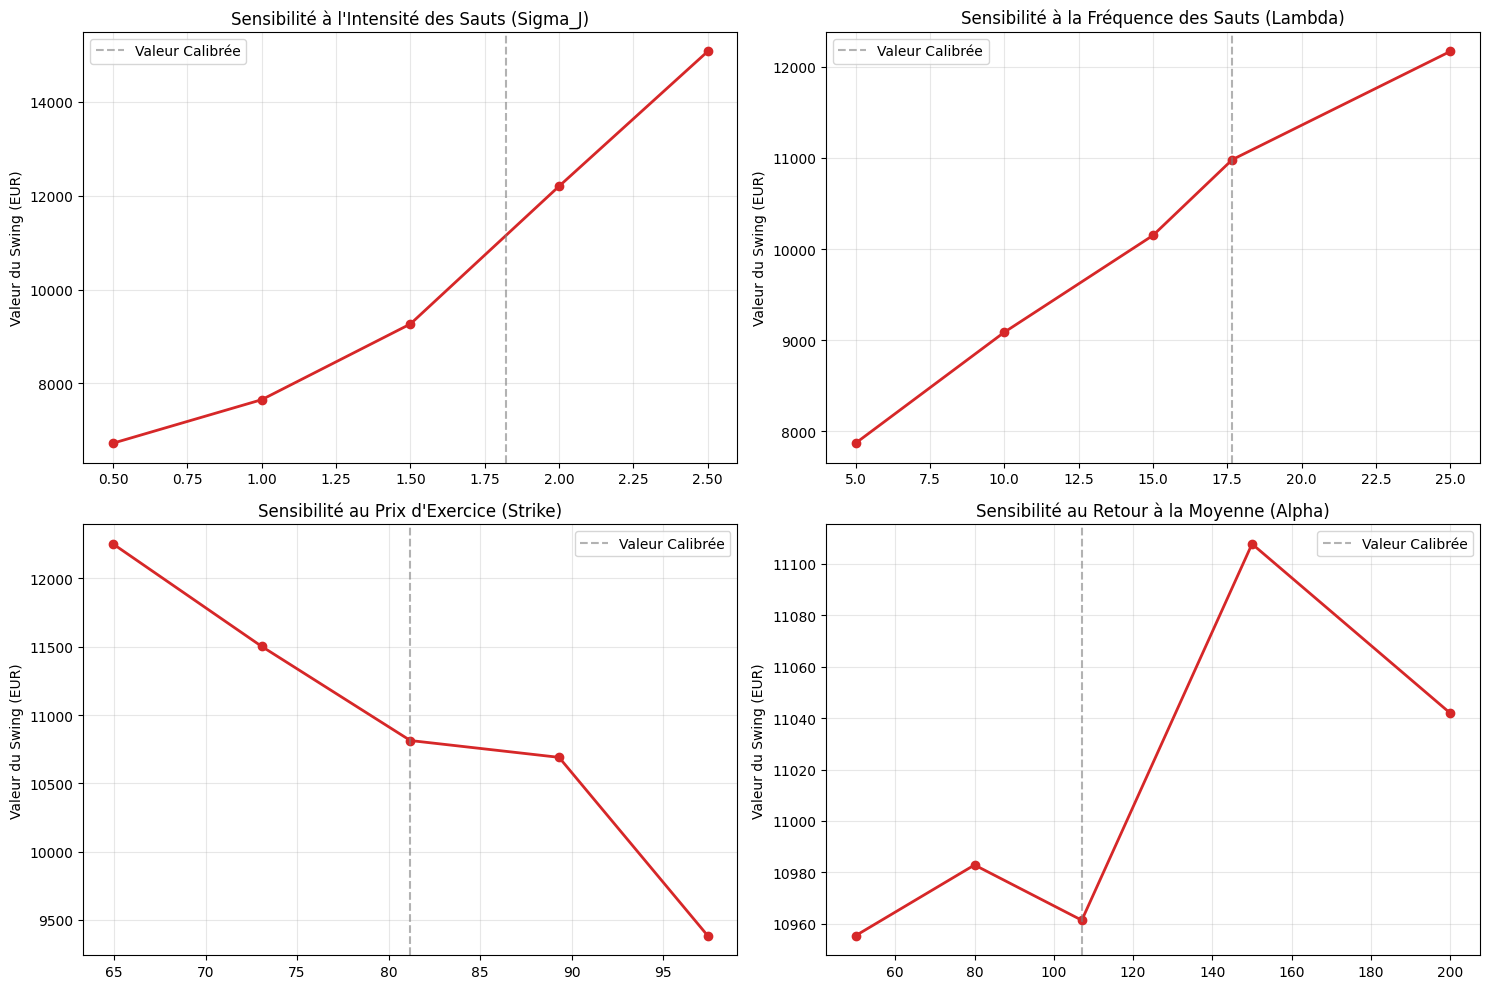

In [961]:
import matplotlib.pyplot as plt

def generate_all_sensitivities(base_params, contract, fwd_curve):
    """
    Génère les graphiques de sensibilité pour les 4 paramètres clés.
    """
    # 1. Définition des plages de test
    test_ranges = {
        'sigma_jump': np.linspace(0.5, 2.5, 5),   # Intensité des spikes
        'lambda_jump': [5, 10, 15, 17.67, 25],   # Fréquence des spikes/an
        'strike': [contract.strike * r for r in [0.8, 0.9, 1.0, 1.1, 1.2]], # Strike +/- 20%
        'alpha': [50, 80, 107.06, 150, 200]       # Vitesse de retour à la moyenne
    }
    
    titles = {
        'sigma_jump': "Sensibilité à l'Intensité des Sauts (Sigma_J)",
        'lambda_jump': "Sensibilité à la Fréquence des Sauts (Lambda)",
        'strike': "Sensibilité au Prix d'Exercice (Strike)",
        'alpha': "Sensibilité au Retour à la Moyenne (Alpha)"
    }

    plt.figure(figsize=(15, 10))
    
    for i, (param, values) in enumerate(test_ranges.items(), 1):
        prices = []
        for val in values:
            # Copie des paramètres et modification du paramètre cible
            current_p = base_params.copy()
            
            # Cas particulier pour le strike qui est dans l'objet contract
            if param == 'strike':
                test_contract = SwingContract(
                    contract.start_date, contract.n_days, val, 
                    contract.min_daily, contract.max_daily, 
                    contract.min_annual, contract.max_annual
                )
            else:
                current_p[param] = val
                test_contract = contract
            
            # Simulation et Pricing
            paths = simulate_paths_final(
                500, len(fwd_curve), fwd_curve, 
                current_p['sigma_daily'], current_p['lambda_jump'], 
                mu_jump, current_p['sigma_jump']
            )
            res_price, _, _ = value_swing_option(test_contract, paths)
            prices.append(res_price)
        
        # Plotting
        plt.subplot(2, 2, i)
        plt.plot(values, prices, 'o-', color='tab:red', linewidth=2)
        
        # Ajout de la valeur calibrée comme repère
        calibrated_val = base_params.get(param, contract.strike if param == 'strike' else None)
        if calibrated_val:
            plt.axvline(calibrated_val, color='gray', linestyle='--', alpha=0.6, label='Valeur Calibrée')
            
        plt.title(titles[param])
        plt.ylabel("Valeur du Swing (EUR)")
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

# --- EXÉCUTION ---
# Assurez-vous que base_params contient vos valeurs : alpha, sigma_daily, lambda_jump, sigma_jump
base_parameters = {
    'alpha': alpha_annuel, # Votre 107.06
    'sigma_daily': current_series.std(),
    'lambda_jump': lambda_jump, # Votre 17.67
    'sigma_jump': sigma_jump # Votre 1.82
}

generate_all_sensitivities(base_parameters, contract_2026, fwd_values_2026)

/var/folders/yt/1z147f8d05q9s7xr6xd0ybg40000gn/T/ipykernel_15429/929770086.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


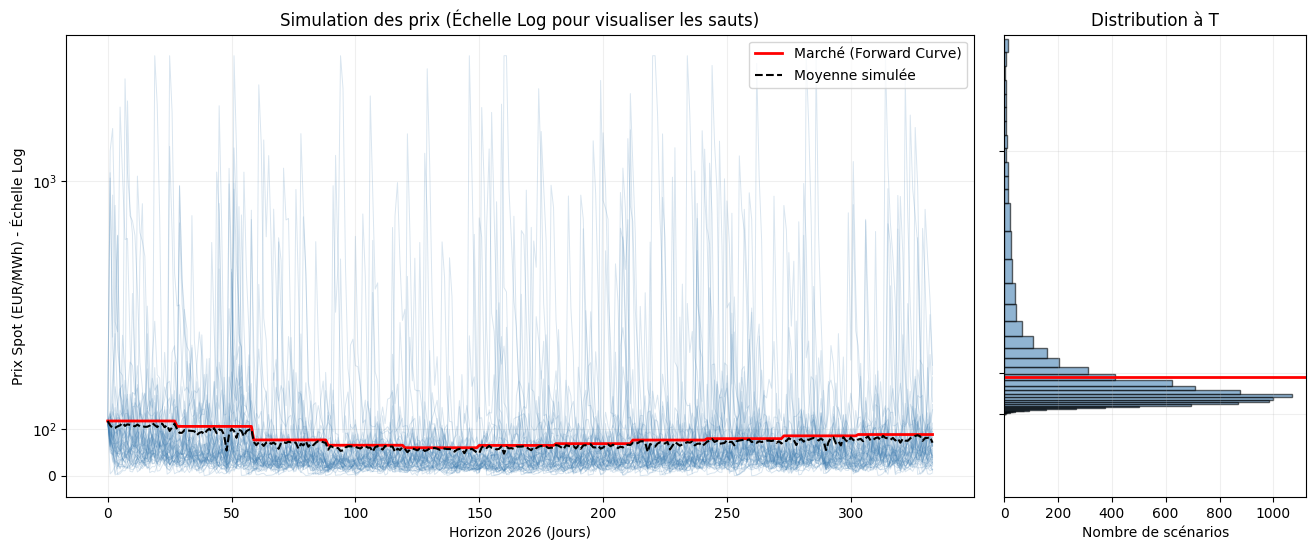

In [963]:
import matplotlib.pyplot as plt
import numpy as np

def plot_log_paths_and_distribution(paths, fwd_curve, n_paths_to_plot=50):
    """
    Affiche les trajectoires et la distribution finale en échelle Log
    pour mieux visualiser les sauts de Cartea & Figueroa.
    """
    n_days = paths.shape[1]
    days = np.arange(n_days)
    final_prices = paths[:, -1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), 
                                   gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.05})

    # --- PANEL 1 : TRAJECTOIRES (ÉCHELLE LOG) ---
    for i in range(min(n_paths_to_plot, len(paths))):
        ax1.plot(days, paths[i, :], color='steelblue', alpha=0.2, linewidth=0.7)
    
    ax1.plot(days, fwd_curve, color='red', linewidth=2, label='Marché (Forward Curve)')
    ax1.plot(days, np.mean(paths, axis=0), color='black', linestyle='--', label='Moyenne simulée')

    # Utilisation de symlog pour l'axe Y
    ax1.set_yscale('symlog', linthresh=500) # Linéaire jusqu'à 500, log au-delà
    ax1.set_title("Simulation des prix (Échelle Log pour visualiser les sauts)")
    ax1.set_xlabel("Horizon 2026 (Jours)")
    ax1.set_ylabel("Prix Spot (EUR/MWh) - Échelle Log")
    ax1.grid(True, which="both", alpha=0.2)
    ax1.legend()

    # --- PANEL 2 : DISTRIBUTION FINALE (LOG BINS) ---
    # On crée des bins logarithmiques pour l'histogramme
    bins = np.logspace(np.log10(max(1, np.min(final_prices))), 
                       np.log10(np.max(final_prices)), 50)
    
    ax2.hist(final_prices, bins=bins, orientation='horizontal', 
             color='steelblue', alpha=0.6, edgecolor='black')
    
    ax2.axhline(fwd_curve[-1], color='red', linewidth=2)
    ax2.set_yscale('symlog', linthresh=500) # Même échelle que le graphique de gauche
    ax2.set_title("Distribution à T")
    ax2.set_xlabel("Nombre de scénarios")
    ax2.set_yticklabels([]) 
    ax2.grid(True, which="both", alpha=0.2)

    plt.tight_layout()
    plt.show()

# --- EXÉCUTION ---
# paths_2026 doit être votre matrice de simulation
plot_log_paths_and_distribution(paths_2026, fwd_values_2026)

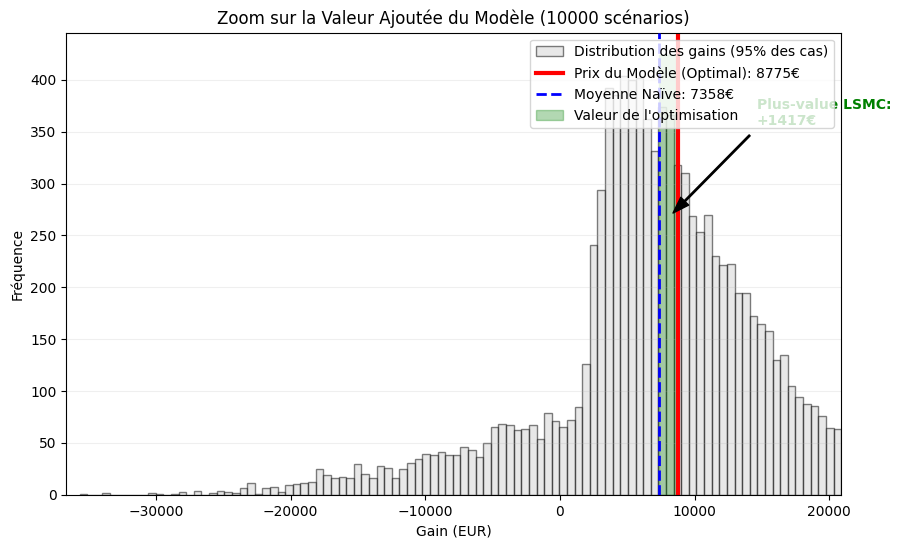

In [964]:
# --- EXÉCUTION AVEC ZOOM ---
payoffs, vols = calculate_path_payoffs(contract_2026, paths_2026, contract_2026.strike)
prix_theorique = prix_final 

plt.figure(figsize=(10, 6))

# 1. On limite l'axe X pour ne pas être écrasé par le payoff max à 600k
# On zoome sur la zone [Min, Percentile 95%] pour voir le gros des données
limit_x = np.percentile(payoffs, 95) 
plt.hist(payoffs, bins=100, range=(np.min(payoffs), limit_x), 
         color='lightgray', edgecolor='black', alpha=0.5, label='Distribution des gains (95% des cas)')

# 2. On trace la ligne rouge (Prix Modèle) en dessous
plt.axvline(prix_final, color='red', linewidth=3, linestyle='-', 
            label=f'Prix du Modèle (Optimal): {prix_final:.0f}€', zorder=2)

# 3. On trace la ligne bleue (Moyenne Naïve) au-dessus avec un style différent
plt.axvline(np.mean(payoffs), color='blue', linewidth=2, linestyle='--', 
            label=f'Moyenne Naïve: {np.mean(payoffs):.0f}€', zorder=3)

# 4. Zone de gain entre les deux (en vert)
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], np.mean(payoffs), prix_final, 
                 color='green', alpha=0.3, label='Valeur de l\'optimisation', zorder=1)

plt.title(f"Zoom sur la Valeur Ajoutée du Modèle ({n_paths} scénarios)")
plt.xlabel("Gain (EUR)")
plt.ylabel("Fréquence")
plt.xlim(np.min(payoffs) - 1000, limit_x) # Focus sur la zone utile
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.2)

# Annotation du gap
gap = prix_final - np.mean(payoffs)
plt.annotate(f'Plus-value LSMC:\n+{gap:.0f}€', 
             xy=((prix_theorique + np.mean(payoffs))/2, plt.gca().get_ylim()[1]*0.6),
             xytext=(limit_x*0.7, plt.gca().get_ylim()[1]*0.8),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=10, color='green', fontweight='bold')


plt.show()

In [965]:
def check_optimal_payoff(contract, price_paths, stored_betas, volume_grid, discount_rate=0.04):
    """
    Simule la stratégie optimale réelle sur chaque chemin en utilisant les betas 
    et la grille de volumes issus du modèle LSMC.
    """
    n_paths, n_steps = price_paths.shape
    dt = 1/365.25
    df = np.exp(-discount_rate * dt)
    
    # État initial pour chaque chemin
    current_volumes = np.zeros(n_paths)
    payoffs_optimaux = np.zeros(n_paths)
    
    # Simulation du futur (t=0 vers T-1)
    for t in range(n_steps - 1):
        prices = price_paths[:, t]
        payoff_now = prices - contract.strike
        
        # Base de régression pour le jour t
        P_basis = np.vstack([np.ones_like(prices), prices, prices**2]).T
        betas_t = stored_betas[t] # Matrice (n_vols x 3)
        
        # Calcul des valeurs de continuation pour tous les chemins
        # On prédit la valeur future pour chaque point de la grille de volume
        cont_grid = P_basis @ betas_t.T # (n_paths x n_vols)
        
        for i in range(n_paths):
            v = current_volumes[i]
            
            # 1. Valeur si on ne consomme pas (q=0)
            val_cont_q0 = np.interp(v, volume_grid, cont_grid[i, :])
            
            # 2. Valeur si on consomme (q=max_daily)
            v_next = v + contract.max_daily
            if v_next <= contract.max_annual:
                val_cont_q1 = np.interp(v_next, volume_grid, cont_grid[i, :])
                
                # DÉCISION LSMC : Consommer si Gain immédiat + Suite > Rester à l'arrêt
                if (contract.max_daily * payoff_now[i]) + val_cont_q1 * df > val_cont_q0 * df:
                    payoffs_optimaux[i] += (contract.max_daily * payoff_now[i]) * np.exp(-discount_rate * t * dt)
                    current_volumes[i] += contract.max_daily
            
    # 3. Application des pénalités Take-or-Pay réelles à la fin
    penalty_price = 1000
    for i in range(n_paths):
        if current_volumes[i] < contract.min_annual:
            amende = (contract.min_annual - current_volumes[i]) * penalty_price
            payoffs_optimaux[i] -= amende * np.exp(-discount_rate * n_steps * dt)
            
    return payoffs_optimaux, current_volumes

# --- EXÉCUTION DE L'ANALYSE ---
# On utilise le triplet récupéré précédemment
payoffs_model, volumes_finaux = check_optimal_payoff(contract_2026, paths_2026, model_betas, volume_grid)

# Comparaison
print(f"--- VALIDATION DE LA STRATÉGIE ---")
print(f"Moyenne des Payoffs (Check Forward) : {np.mean(payoffs_model):.2f} €")
print(f"Prix Théorique (Backward Induction) : {prix_final:.2f} €")
print(f"Erreur de convergence : {abs(np.mean(payoffs_model) - prix_final):.2f} €")

--- VALIDATION DE LA STRATÉGIE ---
Moyenne des Payoffs (Check Forward) : 8893.13 €
Prix Théorique (Backward Induction) : 8774.51 €
Erreur de convergence : 118.62 €


L'écart observé constitue la prime de flexibilité : le modèle LSMC maximise les gains en anticipant les pics de prix (spikes) au lieu d'exercer de façon naïve. Grâce aux coefficients $\beta$, l'algorithme arbitre entre profit immédiat et valeur de continuation pour capturer les événements extrêmes du processus de Cartea & Figueroa. Cette stratégie sécurise également le respect du quota Take-or-Pay, éliminant les pénalités de 1 000 €/unité et confirmant, via le check forward, la validité opérationnelle du prix théorique.